In [ ]:
!pip install torch torchvision numpy pillow matplotlib tqdm
!pip install git+https://github.com/mlfoundations/open_clip.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import open_clip


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class ConditionalSpriteSheetDataset(Dataset):
    def __init__(self, root_dir, img_size=(128, 128)):
        """
                img_size: 128x128 or 64x64.
        """
        self.root_dir = root_dir
        self.img_size = img_size
        self.image_files = [
            f for f in os.listdir(root_dir) if f.lower().endswith(('png', 'jpg'))
        ]


        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])


        self.model, _, _ = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        self.model = self.model.to(device)
        self.model.eval()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])


        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)


        filename = os.path.splitext(self.image_files[idx])[0]

        text_input = filename.replace("_", " ")


        with torch.no_grad():
            tokenized_text = self.tokenizer([text_input]).to(device)
            text_features = self.model.encode_text(tokenized_text)

            text_features = text_features / text_features.norm(dim=-1, keepdim=True)


        return image, text_features.squeeze(0)


dataset = ConditionalSpriteSheetDataset(
    root_dir="/content/spritesheets",
    img_size=(128, 128)
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print("Dataset size:", len(dataset))


TEXT_EMB_DIM = 512
IMAGE_EMB_SIZE = 32768
LATENT_DIM = 128

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Dataset size: 72


In [ ]:
class cVAE(nn.Module):
    def __init__(self, image_emb_size=IMAGE_EMB_SIZE, text_emb_dim=TEXT_EMB_DIM, latent_dim=LATENT_DIM):
        super(cVAE, self).__init__()

        self.img_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.text_encoder = nn.Linear(text_emb_dim, 512)

        self.fc_mu = nn.Linear(32768 + 512, latent_dim)
        self.fc_logvar = nn.Linear(32768 + 512, latent_dim)


        self.fc_decode = nn.Linear(latent_dim + 512, 32768)
        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x_img, x_text):

        img_emb = self.img_encoder(x_img)
        text_emb = self.text_encoder(x_text)
        combined = torch.cat([img_emb, text_emb], dim=1)

        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_text):

        text_emb = self.text_encoder(x_text)
        combined = torch.cat([z, text_emb], dim=1)

        x = self.fc_decode(combined)
        x = x.view(-1, 512, 8, 8)
        x = self.deconv(x)
        return x

    def forward(self, x_img, x_text):
        mu, logvar = self.encode(x_img, x_text)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, x_text)
        return x_recon, mu, logvar

def cvae_loss(recon_x, x, mu, logvar):

    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div




In [ ]:
cvae = cVAE().to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-4)

num_epochs = 1000
cvae.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_img, batch_txt in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_img = batch_img.to(device)
        batch_txt = batch_txt.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = cvae(batch_img, batch_txt)
        loss = cvae_loss(recon, batch_img, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataset)
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")




model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
tokenizer = open_clip.get_tokenizer("ViT-B-32")
model = model.to(device)
model.eval()


Epoch 50/1000: 100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Epoch [50/1000] - Loss: 1342.8293


Epoch 100/1000: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s]


Epoch [100/1000] - Loss: 922.5334


Epoch 150/1000: 100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


Epoch [150/1000] - Loss: 810.3200


Epoch 200/1000: 100%|██████████| 9/9 [00:01<00:00,  8.73it/s]


Epoch [200/1000] - Loss: 677.4296


Epoch 250/1000: 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]


Epoch [250/1000] - Loss: 529.8708


Epoch 300/1000: 100%|██████████| 9/9 [00:00<00:00,  9.20it/s]


Epoch [300/1000] - Loss: 445.0003


Epoch 350/1000: 100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


Epoch [350/1000] - Loss: 389.0834


Epoch 400/1000: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s]


Epoch [400/1000] - Loss: 342.2912


Epoch 450/1000: 100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


Epoch [450/1000] - Loss: 304.3710


Epoch 500/1000: 100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


Epoch [500/1000] - Loss: 274.9315


Epoch 550/1000: 100%|██████████| 9/9 [00:00<00:00,  9.35it/s]


Epoch [550/1000] - Loss: 231.2905


Epoch 600/1000: 100%|██████████| 9/9 [00:01<00:00,  7.18it/s]


Epoch [600/1000] - Loss: 218.8491


Epoch 650/1000: 100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


Epoch [650/1000] - Loss: 195.8397


Epoch 700/1000: 100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


Epoch [700/1000] - Loss: 181.4813


Epoch 750/1000: 100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


Epoch [750/1000] - Loss: 164.9781


Epoch 800/1000: 100%|██████████| 9/9 [00:01<00:00,  8.64it/s]


Epoch [800/1000] - Loss: 150.4987


Epoch 850/1000: 100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


Epoch [850/1000] - Loss: 138.3601


Epoch 900/1000: 100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


Epoch [900/1000] - Loss: 128.1492


Epoch 950/1000: 100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


Epoch [950/1000] - Loss: 123.2095


Epoch 1000/1000: 100%|██████████| 9/9 [00:00<00:00,  9.22it/s]


Epoch [1000/1000] - Loss: 116.2752


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

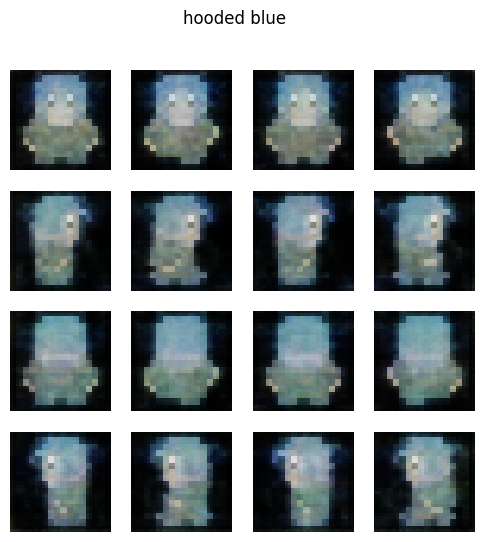

In [ ]:
def generate_sprite_sheet_cvae(prompt, cvae, tokenizer, grid_size=4):
    """
    prompt:  "A cowboy hat"
    cvae: conditional VAE
    tokenizer: CLIP tokenizer
    grid_size: 4 for a 4x4 sheet
    """

    cvae.eval()
    with torch.no_grad():
        tokenized_text = tokenizer([prompt]).to(device)
        text_features = model.encode_text(tokenized_text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)



    z = torch.randn((1, LATENT_DIM), device=device)


    with torch.no_grad():
        generated = cvae.decode(z, text_features)


    sprite = generated.squeeze(0).permute(1, 2, 0).cpu().numpy()

    height, width, _ = sprite.shape
    frame_h = height // grid_size
    frame_w = width // grid_size

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    for i in range(grid_size):
        for j in range(grid_size):
            frame = sprite[
                i * frame_h : (i + 1) * frame_h,
                j * frame_w : (j + 1) * frame_w,
                :
            ]
            axes[i, j].imshow(frame)
            axes[i, j].axis("off")

    plt.suptitle(prompt)
    plt.show()




generate_sprite_sheet_cvae("hooded blue", cvae, tokenizer)